In [111]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt



from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
def correct_data(df):
    """
    Corrects the data by removing outliers and interpolating missing values.

    Parameters:
    - df: pandas DataFrame with at least two columns: 'timestamp' and 'load'.

    Returns:
    - df: corrected pandas DataFrame.
    """
    # Remove outliers
    df['load_diff'] = df['load'].diff(periods=1)
    outlier_idx = df['load_diff'].abs().idxmax()
    df.loc[outlier_idx-2:outlier_idx+2, 'load'] = None
    df['load'] = df['load'].interpolate(method='linear')

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df.index = df.index.round('5min')
    df = df.asfreq('5min')
    df = df.interpolate()

    return df

In [98]:
def plot_actual_vs_forecast(actual_series, forecast_series, title="Actual vs Forecast", xlabel="Time", ylabel="Value"):
    """
    Plots the actual time series and forecast values on the same plot.

    Parameters:
        actual_series (pd.Series): Time-indexed series of actual values.
        forecast_series (pd.Series): Time-indexed series of forecasted values.
        title (str): Plot title.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(actual_series, label='Actual', color='black')
    plt.plot(forecast_series, label='Forecast', color='red', linestyle=(0, (5, 5)), linewidth=2)
    plt.axvline(x=forecast_series.index[0], color='blue', linestyle='--', linewidth=1, label='Forecast Start')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [84]:
df = pd.read_csv(r'../../data/processed/actual_load.csv', parse_dates=['timestamp'])
df = correct_data(df)
df['load_diff'] = df['load'].diff(periods=1)
df = df.dropna(subset=['load_diff'])

In [85]:
df['load'], lambda_ = boxcox(df['load'])
df.drop(columns=['load_diff'], inplace=True)

In [87]:
n = len(df)
split_idx = int(n * 0.8)

train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

In [88]:
model = SimpleExpSmoothing(train['load']).fit(optimized=True)

In [92]:
for key, value in model.params.items():
    print(f"{key}: {value}")
print()

smoothing_level: 0.9999999850988388
smoothing_trend: nan
smoothing_seasonal: nan
damping_trend: nan
initial_level: 5.2547182189854444
initial_trend: nan
initial_seasons: []
use_boxcox: False
lamda: None
remove_bias: False



In [91]:
print(model.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                   load   No. Observations:                 6576
Model:             SimpleExpSmoothing   SSE                              0.002
Optimized:                       True   AIC                         -97873.020
Trend:                           None   BIC                         -97859.438
Seasonal:                        None   AICC                        -97873.014
Seasonal Periods:                None   Date:                 Fri, 23 May 2025
Box-Cox:                        False   Time:                         01:24:48
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level              5.2547182                

In [126]:
forecast = model.forecast(steps=len(test))

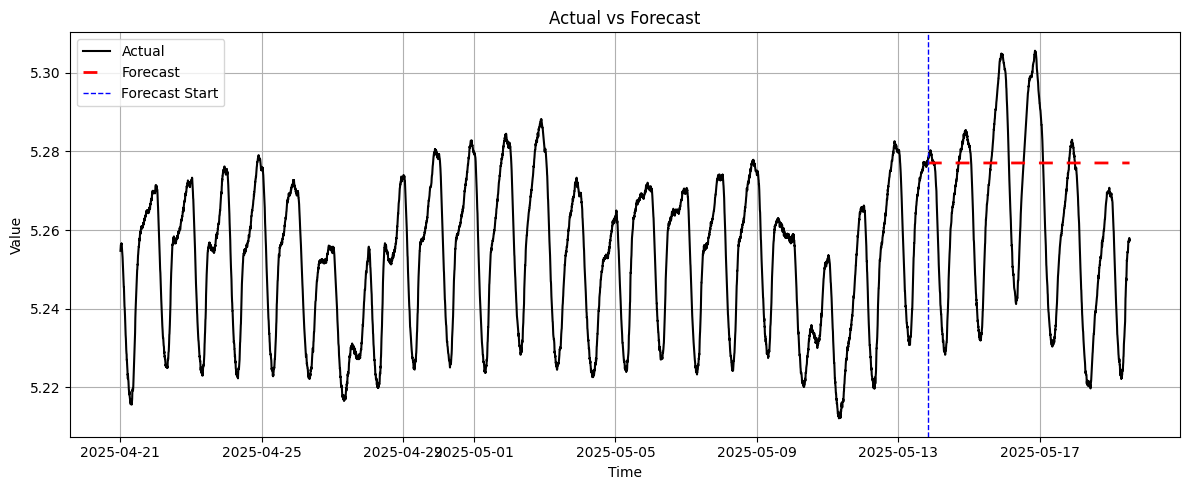

In [99]:
plot_actual_vs_forecast(df['load'], forecast)

In [106]:
model = Holt(train['load'], damped_trend=True).fit(optimized=True)

In [107]:
for key, value in model.params.items():
    print(f"{key}: {value}")
print()

smoothing_level: 0.8771428571428571
smoothing_trend: 0.19735714285714287
smoothing_seasonal: nan
damping_trend: 0.99
initial_level: 5.2547182189854444
initial_trend: 0.0007331353064126134
initial_seasons: []
use_boxcox: False
lamda: None
remove_bias: False



In [108]:
print(model.summary())

                              Holt Model Results                              
Dep. Variable:                   load   No. Observations:                 6576
Model:                           Holt   SSE                              0.001
Optimized:                       True   AIC                        -102599.258
Trend:                       Additive   BIC                        -102565.302
Seasonal:                        None   AICC                       -102599.241
Seasonal Periods:                None   Date:                 Fri, 23 May 2025
Box-Cox:                        False   Time:                         01:56:33
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8771429                alpha                 True
smoothing_trend            0.1973571                

In [109]:
forecast = model.forecast(steps=len(test))

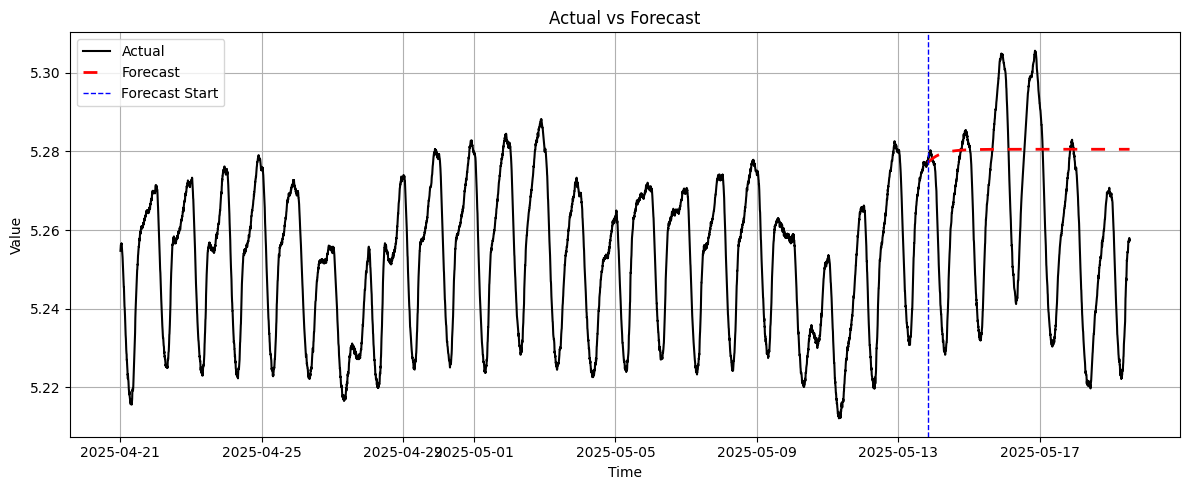

In [110]:
plot_actual_vs_forecast(df['load'], forecast)

In [121]:
model = ExponentialSmoothing(train['load'], trend="add", seasonal="add", seasonal_periods=96).fit(optimized=True)

In [122]:
for key, value in model.params.items():
    print(f"{key}: {value}")
print()

smoothing_level: 0.9620547609429301
smoothing_trend: 0.1391174324645805
smoothing_seasonal: 0.037941884099236205
damping_trend: nan
initial_level: 5.256230013026763
initial_trend: -3.683134555133783e-05
initial_seasons: [-1.47369426e-03 -1.31498714e-03 -1.12819770e-03 -9.72934535e-04
 -6.68078264e-04 -5.85069095e-04 -2.97203623e-04 -5.94761944e-05
  1.29556908e-04  3.84024803e-04  5.27983626e-04  7.08775731e-04
  1.14020598e-03  1.46035489e-03  1.49278010e-03  1.68924133e-03
  1.69981259e-03  1.66825796e-03  1.82408114e-03  2.03891171e-03
  2.14305065e-03  2.10049416e-03  2.18803546e-03  2.24766913e-03
  2.64469633e-03  2.79304654e-03  2.81130484e-03  2.84368299e-03
  2.95902887e-03  2.91738546e-03  2.96796549e-03  2.82822782e-03
  2.72355504e-03  2.47209792e-03  2.36816979e-03  2.29524055e-03
  2.37620108e-03  2.45903647e-03  2.36718489e-03  2.30987897e-03
  2.26704658e-03  2.03553549e-03  1.92959055e-03  1.84993725e-03
  1.66877351e-03  1.46553400e-03  1.31042534e-03  1.15455627e-03


In [123]:
forecast = model.forecast(steps=len(test))

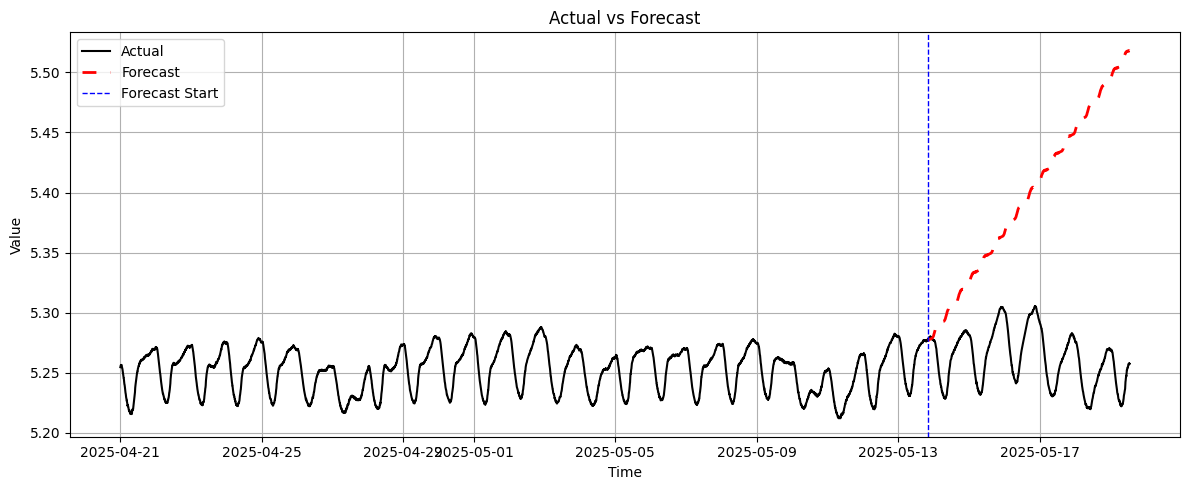

In [124]:
plot_actual_vs_forecast(df['load'], forecast)

<Axes: xlabel='timestamp'>

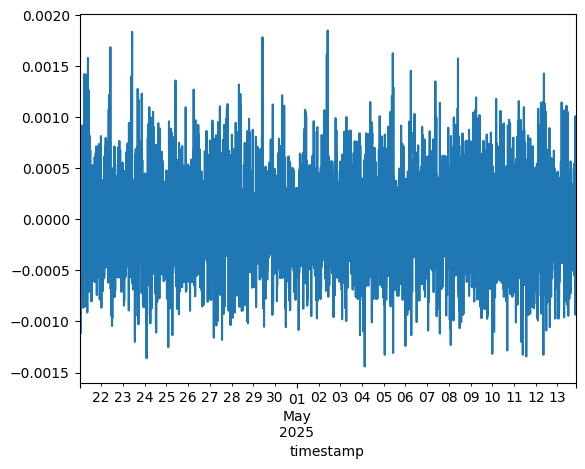

In [125]:
residual = train['load'] - model.fittedvalues
residual.plot()